# Prework

## Import packages and data

In [1]:
import sys
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
import statsmodels.api as sm
from math import sqrt as math_sqrt
from sklearn.metrics import mean_squared_error
import pickle
import math
import random
from tqdm import tqdm

#Import custom modules
sys.path.append('../')
from utils.utils import *

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.4.1
Eager execution: True


## Load data

In [3]:
training_data, testing_data, testing_index = load_data()
countries, no_features, feature_names, years, months, weekdays, hours = load_data_information()

## Adjust data format

In [4]:
# Extracts features, year, etc. from whole data
def change_format(input_data):
    #Extract year from data matrix
    year_w = input_data[:,:,0]
    #Extract weekday from data matrix
    weekday_w = input_data[:,:,1]
    #Extract hour from data matrix
    hour_w = input_data[:,:,2]
    #Extract country from data matrix
    country_w = input_data[:,0:1,3]   
    #Extract month from data matrix
    month_w = input_data[:,:,4:5]
    #Extract features from matrix
    features_w = input_data[:,:,5:5+no_features]
    #Extract matrix of missing values from data matrix
    miss_vals_w = input_data[:,:,-no_features-6:-6]
    #Extract pos enc from data matrix
    pos_enc_w = input_data[:,:,-6:]
   

    return features_w, miss_vals_w, pos_enc_w, country_w, year_w, hour_w, weekday_w
#testing
features, miss_vals, pos_enc, country, year, hour, weekday = change_format(training_data[19:21])

Anpassen der Anzahl der missing values und welches feature gemasked werden soll

Features: PV-12 ; Wind-Onshore-14

In [5]:
number_miss_vals = no_features*12 # number of missing values per day (maximum is features masked times 24)
masked_feature = 12 # country and year do not count
all_masked = 1 # if all inserted features should be masked randomly (if 1, masked feature is not needed)

Funktion um Maske über Features zu legen

In [6]:
def mask_features(features, miss_vals):   
    #Reshape mask to flat array to choose random samples
    mask = np.zeros(shape = (features.shape[0], features.shape[1]*features.shape[2]))
    for sample in range(features.shape[0]):
        if all_masked == 1:
            #Draw number of missing values from Binomial distribution
            p = np.random.uniform(0.2,0.8)
            number_miss_vals = np.random.binomial(n=24*no_features, p = p)
            idx_all = list(range(24*no_features)) # all features masked
        else:
            idx_all = list(range(masked_feature,24*no_features,no_features)) # just one feature masked
        #Shuffle indices
        np.random.shuffle(idx_all)
        idx = idx_all[:number_miss_vals]
        for mv in range(number_miss_vals):
            #Insert mask at the middle day of the week
            mask[sample, (2*24)*no_features + idx[mv]] = 1
            
    #Reshape mask into original shape
    mask = mask.reshape(features.shape)
    #Remove missing values from mask
    mask[np.array(miss_vals)==1]=0
    #Mask features
    features_masked = np.array(features)
    features_masked[mask==1] = 0
    #Set miss vals to 1 in miss_vals
    miss_vals_masked = np.array(miss_vals)
    miss_vals_masked[mask==1] = 1
    

    return features_masked, miss_vals_masked, mask
features_masked, miss_vals_masked, mask = mask_features(features, miss_vals)

## Create validation split and fetch data

Create function for validation split

In [7]:
def val_split(data, split = 0.2):
    size = int(data.shape[0]*split)
    index = data.shape[0]
    split_index = random.choices(range(index),k=size)
    data_val = data[split_index]
    data_train = np.delete(data,split_index,axis=0)
    
    return data_train, data_val

# LSTM Model

In [8]:
def loss_function(real, pred, mask):
    real = real[mask==1]
    pred = pred[mask==1]
    real = tf.dtypes.cast(real, tf.float32)
    error = real-pred
    error = tf.square(error)
    loss = tf.math.sqrt(tf.math.reduce_mean(error))*1000 # sonst so klein ;-)
    return loss

In [9]:
class Bi_LSTM(tf.keras.Model):
    def __init__(self, no_features, rate = 0.1):
        super(Bi_LSTM, self).__init__()

        #Embedding layers
        self.embedding_country = tf.keras.layers.Embedding(countries.shape[0], 9)
        self.embedding_year = tf.keras.layers.Embedding(years.shape[0], 4) 
        
        #LSTM Layer
        self.lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(no_features, return_sequences = True, dropout = rate))

        #Final Dense Layers
        self.final_layer = tf.keras.layers.Dense(no_features)
        
    
    def call(self, input_call):
        country, year, hour, weekday, features_masked, miss_vals_masked, pos_enc = input_call
        
  
        #Embeddings
        country_emb = self.embedding_country(country)
        year_emb = self.embedding_year(year)        
        
        # concatenation (embeddings plus features)
        inp = tf.concat([pos_enc, 
                        tf.repeat(country_emb, pos_enc.shape[1], axis = 1),
                        year_emb, 
                        features_masked,
                        miss_vals_masked], axis = 2)
                
        #LSTM Layer
        lstm_output = self.lstm_layer(inp)      
        #Final Dense Layer
        final_output = self.final_layer(lstm_output)

        return final_output

In [10]:
def train_step(country, year, hour, weekday, features, features_masked, miss_vals_masked, pos_enc, mask):
    #Extract input
    training = True
    with tf.GradientTape() as tape:

        pred = lstm([country, year, hour, weekday, features_masked, miss_vals_masked, pos_enc])            
        loss = loss_function(features, pred, mask)

    gradients = tape.gradient(loss, lstm.trainable_variables)           
    optimizer.apply_gradients(zip(gradients, lstm.trainable_variables))
    return loss, pred

In [11]:
lstm = Bi_LSTM(no_features)

In [12]:
BATCH_SIZE = 32
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [13]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

## Create learning rate and early stopping scheduler

In [14]:
checkpoint_path = "./checkpoints/lstm"

ckpt = tf.train.Checkpoint(lstm=lstm,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [15]:
class Scheduler:
    def __init__(self, checkpoint, checkpoint_manager, learning_rate, patience = 2, delta = 5, fine_tuning = False, min_epochs = 10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.checkpoint_manager = checkpoint_manager
        self.checkpoint = checkpoint
        self.learning_rate = learning_rate
        self.fine_tuning = fine_tuning
        self.min_epochs = min_epochs

    def __call__(self, metric, epoch):
        #Check if score is not initialized
        if self.best_score is None:
            self.best_score = metric
            return (False,self.learning_rate)
        
        #Check for minimum amount of epochs
        if epoch <= self.min_epochs:
            if metric <= self.best_score + self.delta:
                self.best_score = metric
                ckpt_save_path = self.checkpoint_manager.save()
                print(f'Saving checkpoint at {ckpt_save_path}')
            return (False, self.learning_rate)
        
        #If score is worse than before
        if metric > self.best_score + self.delta:
            self.counter += 1
            #If score is still in patience
            if self.counter >= self.patience:
                #If fine tuning is already running
                if self.fine_tuning==True:
                    print("Training finished")
                    return (True,self.learning_rate)
                else:
                    self.fine_tuning=True
                    self.counter = 0
                    self.learning_rate = self.learning_rate/2
                    self.patience += 2
                    if self.checkpoint_manager.latest_checkpoint:
                        self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
                        print('Latest checkpoint restored!!')
                    print(f'Learning rate adjusted to {np.round(self.learning_rate,6)}')
                    self.patience +=2
                    return (False,self.learning_rate)
            else:                
                return (False,self.learning_rate)
        #If score is better   
        else:
            self.best_score = metric
            ckpt_save_path = self.checkpoint_manager.save()
            print(f'Saving checkpoint at {ckpt_save_path}')
            self.counter = 0        
            return (False,self.learning_rate)

In [16]:
scheduler = Scheduler(ckpt, ckpt_manager, learning_rate, patience = 3, delta = 2, fine_tuning=False, min_epochs = 0)
last_val_loss = 1000
scheduler(last_val_loss,0)

(False, 0.001)

## Create training Loop

In [25]:
last_epoch = 0

In [26]:
EPOCHS = 100
losses = [[],[]]



for epoch in range(last_epoch, last_epoch + EPOCHS):        
    # split train data in train and val sets
    samples_train, samples_val = val_split(training_data)

    # create train dataset
    data_train = tf.data.Dataset.from_tensor_slices(samples_train)
    data_train = data_train.cache()
    data_train = data_train.shuffle(samples_train.shape[0]).padded_batch(BATCH_SIZE) #, drop_remainder=True
    data_train = data_train.prefetch(tf.data.experimental.AUTOTUNE)


    # create val dataset 
    data_val = tf.data.Dataset.from_tensor_slices(samples_val)
    data_val = data_val.cache()
    data_val = data_val.shuffle(samples_val.shape[0]).padded_batch(BATCH_SIZE) #, drop_remainder=True
    data_val = data_val.prefetch(tf.data.experimental.AUTOTUNE)

    train_loss.reset_states()
    val_loss.reset_states()
    
    
    train_counter = 0
    running_train_loss = 0
    # train the model
    for (batch, data_inp) in tqdm(enumerate(data_train), desc = "Loading..", total = int(np.ceil(samples_train.shape[0]/BATCH_SIZE))):
        train_counter += 1
        features, miss_vals, pos_enc, country, year, hour, weekday  = change_format(data_inp)
        features_masked, miss_vals_masked, mask = mask_features(features, miss_vals)

        loss, pred = train_step(country, year, hour, weekday, features, features_masked,
                                                miss_vals_masked, pos_enc, mask)
        
        #Save loss to tensorboard
        running_train_loss += loss
        if train_counter % 100 == 0:
            with train_writer.as_default():
                tf.summary.scalar('train_loss', running_train_loss/100, step=(epoch*len(samples_train)+train_counter*BATCH_SIZE))
                running_train_loss = 0
            

        train_loss(loss)
    losses[0].append(train_loss.result())
    

    # validation data calculation
    for (batch, data_inp) in enumerate(data_val):
        features, miss_vals, pos_enc, country, year, hour, weekday  = change_format(data_inp)
        features_masked, miss_vals_masked, mask = mask_features(features, miss_vals)

        pred = lstm([country, year, hour, weekday, features_masked, miss_vals_masked,
                            pos_enc])
        loss = loss_function(features, pred, mask)
        val_loss(loss)
    losses[1].append(val_loss.result())
                                  
    #Save validation data to log
    with train_writer.as_default():
        tf.summary.scalar('val_loss', val_loss.result(), step=((epoch+1)*len(samples_train)))
                
    print ('Epoch {} - Loss {:.4f} val_Loss {:.4f} '.format(
        epoch + 1, train_loss.result(), val_loss.result()))

    #Check early stopping and checkpointing
    stopping, learning_rate = scheduler(float(val_loss.result()),epoch)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    if stopping == True:
        break

Loading..: 100%|███████████████████████████████████████████████████████████████████| 1351/1351 [00:51<00:00, 26.19it/s]


Epoch 3 - Loss 265.4586 val_Loss 247.1915 


Loading..: 100%|███████████████████████████████████████████████████████████████████| 1351/1351 [00:47<00:00, 28.30it/s]


Epoch 4 - Loss 244.9958 val_Loss 241.6627 


Loading..: 100%|███████████████████████████████████████████████████████████████████| 1349/1349 [00:48<00:00, 27.85it/s]


Epoch 5 - Loss 231.0119 val_Loss 222.8958 


Loading..: 100%|███████████████████████████████████████████████████████████████████| 1350/1350 [00:47<00:00, 28.15it/s]


Epoch 6 - Loss 230.0208 val_Loss 214.9606 


Loading..: 100%|███████████████████████████████████████████████████████████████████| 1350/1350 [00:46<00:00, 29.21it/s]


Epoch 7 - Loss 213.1001 val_Loss 215.0929 
Latest checkpoint restored!!
Learning rate adjusted to 0.0005


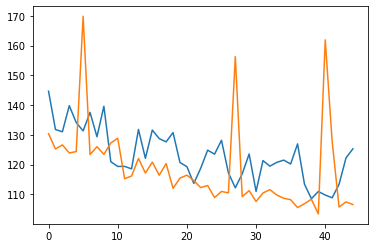

In [19]:
plt.plot(losses[0])
plt.plot(losses[1])

# Predict Test dataset

In [14]:
lstm.load_weights('weights/lstm/lstm_weights')

## Load testing mask

In [16]:
#Function for testing mask
def get_testing_mask(features, miss_vals, mask):
    #mask = mask.reshape(features.shape)
    features_masked = np.array(features)
    features_masked[mask==1] = 0
    miss_vals_masked = np.array(miss_vals)
    miss_vals_masked[mask==1] = 1
    
    return features_masked, miss_vals_masked, mask

In [17]:
#Fetch testing data
data_test = tf.data.Dataset.from_tensor_slices(testing_data)
data_test = data_test.cache()
data_test = data_test.padded_batch(BATCH_SIZE) #, drop_remainder=True
data_test = data_test.prefetch(tf.data.experimental.AUTOTUNE)

# Prediction of testing masks

## Loop over all testing masks

In [26]:
for p in np.round(np.arange(0.1,1,0.1),1):
    #Load testing mask
    testing_mask=np.load("../evaluation/masks/testing_mask_{}.npy".format(p))
    #Create empty arrays for Results
    prediction = np.array([])
    values_act=np.array([])


    for (batch, data_inp) in enumerate(data_test):    
        features, miss_vals, pos_enc, country, year, hour, weekday  = change_format(data_inp)
        features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE])

        pred = lstm([country, year, hour, weekday, features_masked, miss_vals_masked,
                            pos_enc])

        #Add real values and prediction to dataframe
        values_act = np.append(values_act,np.array(features)[mask==1].flatten())
        prediction = np.append(prediction,pred[mask==1].numpy())
        
    #Print mse
    mse = mean_squared_error(values_act,prediction)
    print(mse)
        
    #Save results
    np.save("../data/predictions/lstm_pred_{}".format(p),prediction)

0.015820992157565942
0.018583290072389735
0.019953433678428268
0.02222003157116792
0.02576310284040559
0.029795893372913784
0.033881391188817014
0.04355280550449776
0.056916515529142064


## Estimated testing mask

In [19]:
#Prepare testing mask
testing_mask_raw = np.load("../evaluation/masks/testing_mask_estimated.npy")
testing_mask = np.zeros(shape = (testing_mask_raw.shape[0],120,no_features))
testing_mask[:,2*24:3*24] = testing_mask_raw
#Create empty arrays for Results
prediction = np.array([])
values_act=np.array([])


for (batch, data_inp) in enumerate(data_test):    
    features, miss_vals, pos_enc, country, year, hour, weekday  = change_format(data_inp)
    features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE])

    pred = lstm([country, year, hour, weekday, features_masked, miss_vals_masked,
                        pos_enc])

    #Add real values and prediction to dataframe
    values_act = np.append(values_act,np.array(features)[mask==1].flatten())
    prediction = np.append(prediction,pred[mask==1].numpy())

#Print mse
mse = mean_squared_error(values_act,prediction)
print(mse)

np.save("../data/predictions/lstm_pred_estimated",prediction)

0.0677857490545821
